In [3]:
import numpy as np
import os
import gzip
import struct
import random
import time
import signal
import hashlib

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'bilinear'
plt.rcParams['image.cmap'] = 'gray'

from IPython.display import clear_output, display

from netlib import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
class FCN(Net):
    def __init__(self, sizes):
        layers = [n for sx, sy in zip(sizes[:-1], sizes[1:]) for n in [Affine(sx, sy), Bias(sy), ReLU()]][:-1]
        links = [(i - 1, i) for i in range(len(layers))] + [(len(layers) - 1, -1)]
        super().__init__(layers, links)

In [94]:
digest_bytes = 16 # MD5

hparams = {
    "digest_bytes": digest_bytes,
    "hash_init_bytes": digest_bytes,
    "nonce_bytes": 8,
    "pred_bits": 1
}

batch_size = 1000

In [95]:
def rand_bytes(l):
    return np.random.bytes(l)

def rand_hashes(count, hash_init_bytes):
    cs = hash_init_bytes//8
    bs = rand_bytes(count*cs)
    return [hashlib.md5(bs[i*cs:(i+1)*cs]) for i in range(count)]

def make_inputs(hs, ns):
    bs = b""
    for h, n in zip(hs, ns):
        bs += h.digest()
        h.update(n)
        bs += h.digest()
    return bs

def bytes_to_npbits(bs, count):
    return np.unpackbits(np.frombuffer(bs, dtype=np.uint8)).reshape(count, -1)

def make_batch(batch_size, **kwargs):
    hs = rand_hashes(batch_size, kwargs["hash_init_bytes"])
    ns = rand_bytes(batch_size*kwargs["nonce_bytes"]//8)
    xs = make_inputs(hs, [ns[i*kwargs["nonce_bytes"]:(i+1)*kwargs["nonce_bytes"]] for i in range(batch_size)])
    return (
        bytes_to_npbits(xs, batch_size)[:,:8*kwargs["digest_bytes"] + kwargs["pred_bits"]], 
        bytes_to_npbits(ns, batch_size)
    )

print(make_batch(batch_size, **hparams)[0].shape)

(1000, 129)


In [96]:
signal_done = False

def signal_handler(signal, frame):
    global signal_done
    signal_done = True

def stop_on_signal():
    global signal_done
    signal_done = False
    signal.signal(signal.SIGINT, signal_handler)

In [97]:
class Solver:
    def __init__(self, net, optims, **params):
        self.params = params
        self.name = params["name"]
        self.net = net
        
        if isinstance(optims, Optim):
            optims = [optims]
        self.optims = optims
        
    def learn(self, x, r):
        y, m = self.net.forward(x)
        by = np.greater(y, 0)
        loss = rms_loss(by, r)

        grad = self.net.newgrad()
        self.net.backward(grad, m, rms_deriv(by, r))

        #modgrad(grad, norm=1, clip=5)
        for optim in self.optims:
            optim.learn(self.net, grad)

        return loss

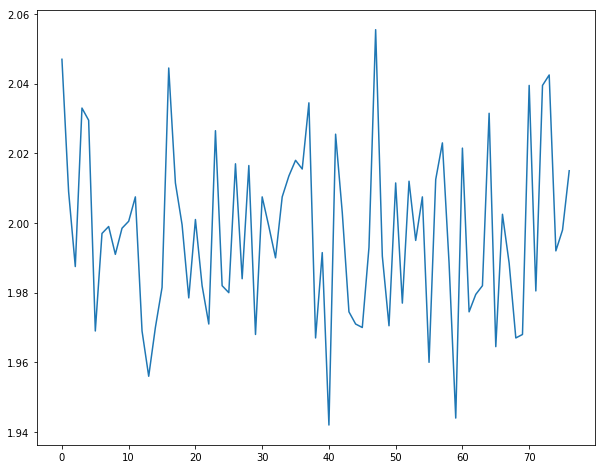

In [98]:
sol = Solver(
    FCN((8*hparams["digest_bytes"] + hparams["pred_bits"], 256, 256, nonce_size)),
    Adam(1e-3), name="(256,256),Adam(1e-3)"
)
loss_history = []
pos = 0

stop_on_signal()
while not signal_done:
    loss = sol.learn(*make_batch(batch_size, **hparams))
    if pos % 1000 == 0:
        loss_history.append(loss)
        clear_output(wait=True)
        plt.plot(loss_history)
        plt.show()
    pos += 1